# 03 — Client Engagement Diagnostics

**Intent:** Audit engagement patterns and model behavior using cohort, funnel, calibration, ranking, and simple policy comparisons.

This notebook explores additional client engagement analytics beyond model training:

1. Cohort retention and reactivation
2. Segment-level engagement funnel
3. Time-slot stability analysis
4. Calibration and ranking quality
5. What-if sensitivity checks
6. Business policy simulation

Inputs used:
- `data/processed/transactions_clean.csv`
- `data/synthetic/campaign_events.csv`
- `data/processed/customer_features.csv`
- `data/processed/event_features.csv`
- trained model artifacts from `src/train.py`

**References (optional reading):**
- Hughes, A. M. (1994). *Strategic Database Marketing* (popularizes RFM segmentation in practice).
- Brier, G. W. (1950). *Verification of forecasts expressed in terms of probability*. Monthly Weather Review.
- Niculescu-Mizil, A., & Caruana, R. (2005). *Predicting Good Probabilities with Supervised Learning*. ICML.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
from sklearn.metrics import brier_score_loss

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.feature_engineering import FEATURE_COLUMNS, build_168_grid

pd.set_option('display.max_columns', 120)

## 0. Load Data & Artifacts

**Intent:** Load transaction/campaign/customer/event datasets and the saved model + calibrator artifacts.

In [2]:
TXN_PATH = PROJECT_ROOT / 'data' / 'processed' / 'transactions_clean.csv'
CMP_PATH = PROJECT_ROOT / 'data' / 'synthetic' / 'campaign_events.csv'
CUST_PATH = PROJECT_ROOT / 'data' / 'processed' / 'customer_features.csv'
EVT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'event_features.csv'
MODEL_PATH = PROJECT_ROOT / 'models' / 'lgbm_time_to_engage.pkl'
CAL_PATH = PROJECT_ROOT / 'models' / 'probability_calibrator.pkl'

for p in [TXN_PATH, CMP_PATH, CUST_PATH, EVT_PATH, MODEL_PATH, CAL_PATH]:
    assert p.exists(), f'Missing required file: {p}'

transactions = pd.read_csv(TXN_PATH, parse_dates=['InvoiceDate'])
campaign = pd.read_csv(CMP_PATH, parse_dates=['send_datetime'])
customers = pd.read_csv(CUST_PATH)
customers['customer_id'] = customers['customer_id'].astype(np.int64)
events = pd.read_csv(EVT_PATH, parse_dates=['send_datetime'])

model = joblib.load(MODEL_PATH)
calibrator = joblib.load(CAL_PATH)

print('transactions:', transactions.shape)
print('campaign:', campaign.shape)
print('customers:', customers.shape)
print('events:', events.shape)

transactions: (689357, 8)
campaign: (106154, 9)
customers: (5335, 13)
events: (106154, 23)


## 1) Cohort Retention & Reactivation

**Intent:** Measure how long customers keep buying after their first purchase (retention) and how often they "come back" after long gaps (reactivation).

In [3]:
txn = transactions[['CustomerID', 'InvoiceDate']].copy()
txn['month'] = txn['InvoiceDate'].dt.to_period('M')
first_month = txn.groupby('CustomerID')['month'].min().rename('cohort_month')
cohort_df = txn.merge(first_month, on='CustomerID', how='left')
cohort_df['month_idx'] = (cohort_df['month'] - cohort_df['cohort_month']).apply(lambda x: x.n)

cohort_size = cohort_df.groupby('cohort_month')['CustomerID'].nunique()
ret = cohort_df.groupby(['cohort_month', 'month_idx'])['CustomerID'].nunique().unstack(fill_value=0)
ret_rate = ret.div(cohort_size, axis=0)

print('Cohort table shape:', ret_rate.shape)
ret_rate.iloc[:8, :12]

Cohort table shape: (25, 25)


month_idx,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2009-12,1.0,0.349224,0.328160,0.421286,0.375831,0.356984,0.370288,0.344789,0.337029,0.352550,0.417960,0.493348
2010-01,1.0,0.211765,0.320588,0.317647,0.264706,0.320588,0.255882,0.235294,0.276471,0.323529,0.308824,0.173529
2010-02,1.0,0.235465,0.223837,0.305233,0.241279,0.203488,0.183140,0.287791,0.258721,0.276163,0.116279,0.113372
2010-03,1.0,0.197080,0.238443,0.248175,0.233577,0.211679,0.253041,0.309002,0.282238,0.109489,0.114355,0.145985
2010-04,1.0,0.194030,0.205224,0.167910,0.190299,0.220149,0.276119,0.261194,0.100746,0.093284,0.074627,0.134328
2010-05,1.0,0.153846,0.170940,0.179487,0.179487,0.252137,0.222222,0.128205,0.059829,0.064103,0.111111,0.128205
2010-06,1.0,0.172840,0.193416,0.209877,0.230453,0.288066,0.131687,0.078189,0.082305,0.111111,0.102881,0.139918
2010-07,1.0,0.153374,0.171779,0.300613,0.282209,0.134969,0.092025,0.128834,0.122699,0.116564,0.110429,0.147239


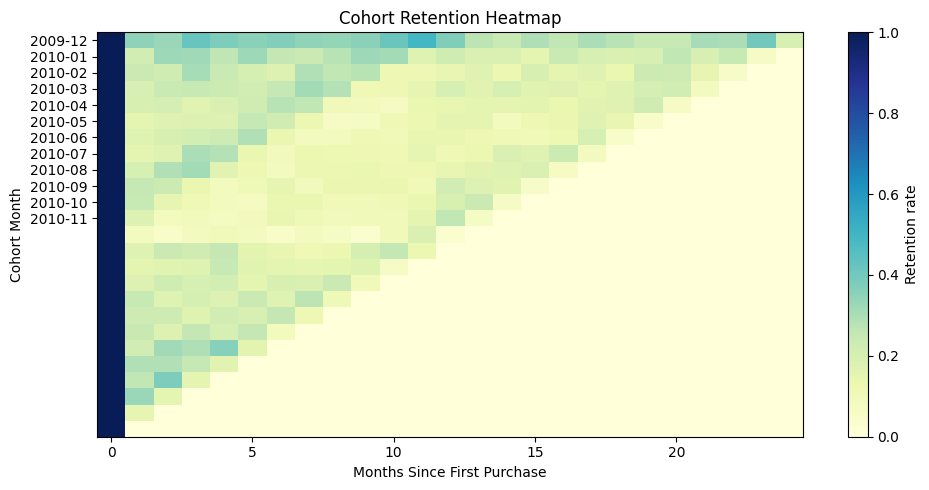

In [4]:
plt.figure(figsize=(10, 5))
plt.imshow(ret_rate.fillna(0).values, aspect='auto', cmap='YlGnBu')
plt.colorbar(label='Retention rate')
plt.title('Cohort Retention Heatmap')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.yticks(range(min(12, len(ret_rate.index))), [str(x) for x in ret_rate.index[:12]])
plt.tight_layout()
plt.show()

In [5]:
txn_sorted = txn.sort_values(['CustomerID', 'InvoiceDate']).copy()
txn_sorted['prev_date'] = txn_sorted.groupby('CustomerID')['InvoiceDate'].shift(1)
txn_sorted['gap_days'] = (txn_sorted['InvoiceDate'] - txn_sorted['prev_date']).dt.days

# Filter to non-null gaps (exclude first transaction per customer which has NaN gap)
gaps = txn_sorted['gap_days'].dropna()
reactivation = {k: float((gaps >= k).mean()) for k in [30, 60, 90]}
reactivation

{30: 0.018597355055831537, 60: 0.010618079535453538, 90: 0.007099186868258623}

## 2) Segment-Level Engagement Funnel

**Intent:** Compare engagement performance by customer segment (sent -> opened -> clicked -> purchased) to identify where different segments drop off.

In [6]:
funnel = campaign.merge(customers[['customer_id', 'rfm_segment']], on='customer_id', how='left')

agg = funnel.groupby('rfm_segment').agg(
    sent=('campaign_id', 'count'),
    opens=('opened', 'sum'),
    clicks=('clicked', 'sum'),
    purchases=('purchased', 'sum'),
).reset_index()

agg['open_rate'] = agg['opens'] / agg['sent']
agg['click_rate_given_open'] = np.where(agg['opens'] > 0, agg['clicks'] / agg['opens'], 0.0)
agg['purchase_rate_given_click'] = np.where(agg['clicks'] > 0, agg['purchases'] / agg['clicks'], 0.0)
agg.sort_values('open_rate', ascending=False)

,rfm_segment,sent,opens,clicks,purchases,open_rate,click_rate_given_open,purchase_rate_given_click
2,Hibernating,1167,287,107,14,0.245930,0.372822,0.130841
4,Other,9196,2202,761,89,0.239452,0.345595,0.116951
3,Loyal,46050,10838,3823,481,0.235353,0.352740,0.125817
0,At Risk,12084,2841,987,118,0.235104,0.347413,0.119554
1,Champions,37657,8812,3149,355,0.234007,0.357354,0.112734


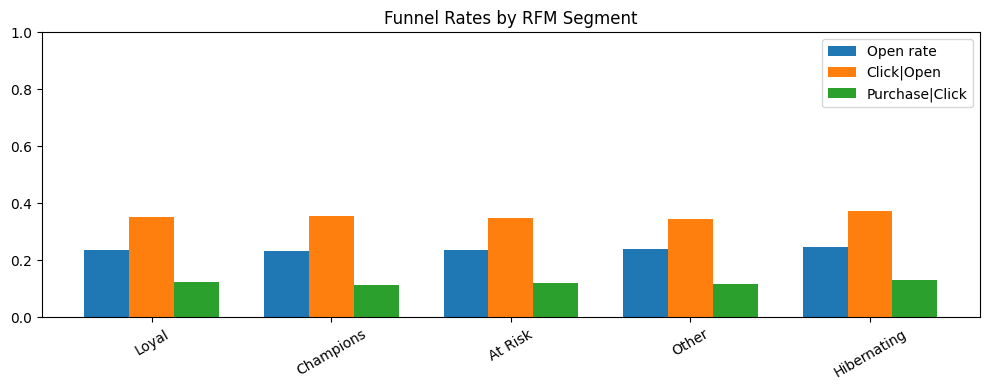

In [7]:
plot_df = agg.sort_values('sent', ascending=False)
ix = np.arange(len(plot_df))
width = 0.25

plt.figure(figsize=(10, 4))
plt.bar(ix - width, plot_df['open_rate'], width=width, label='Open rate')
plt.bar(ix, plot_df['click_rate_given_open'], width=width, label='Click|Open')
plt.bar(ix + width, plot_df['purchase_rate_given_click'], width=width, label='Purchase|Click')
plt.xticks(ix, plot_df['rfm_segment'], rotation=30)
plt.ylim(0, 1)
plt.title('Funnel Rates by RFM Segment')
plt.legend()
plt.tight_layout()
plt.show()

## 3) Time-Slot Stability (Early vs Late Period)

**Intent:** Check whether customers' "best" send time is stable over time — important for deciding how often to refresh personalization.

In [8]:
campaign['period'] = np.where(
    campaign['send_datetime'] <= campaign['send_datetime'].median(),
    'early', 'late'
)

slot_pref = (
    campaign.groupby(['period', 'customer_id', 'send_dow', 'send_hour'])['opened']
    .mean()
    .reset_index()
)

best_slot = (
    slot_pref.sort_values(['period', 'customer_id', 'opened'], ascending=[True, True, False])
    .drop_duplicates(['period', 'customer_id'])
    [['period', 'customer_id', 'send_dow', 'send_hour']]
)

early = best_slot[best_slot['period'] == 'early'].drop(columns='period').rename(columns={'send_dow': 'early_dow', 'send_hour': 'early_hour'})
late = best_slot[best_slot['period'] == 'late'].drop(columns='period').rename(columns={'send_dow': 'late_dow', 'send_hour': 'late_hour'})

stability = early.merge(late, on='customer_id', how='inner')
stability['same_slot'] = (stability['early_dow'] == stability['late_dow']) & (stability['early_hour'] == stability['late_hour'])

stability_rate = stability['same_slot'].mean() if len(stability) else np.nan
{'customers_compared': int(len(stability)), 'slot_stability_rate': float(stability_rate)}

{'customers_compared': 4184, 'slot_stability_rate': 0.0511472275334608}

## 4) Calibration & Ranking Quality

**Intent:** Evaluate whether predicted probabilities are trustworthy (calibration) and whether the model ranks the best send times near the top (top-k quality).

In [9]:
X = events[FEATURE_COLUMNS]
y = events['opened'].astype(int).values
raw = model.predict_proba(X)[:, 1]
cal = calibrator.predict(raw)

cal_df = pd.DataFrame({'y': y, 'p': cal})
cal_df['bin'] = pd.qcut(cal_df['p'], q=10, duplicates='drop')
cal_curve = cal_df.groupby('bin', observed=False).agg(
    mean_pred=('p', 'mean'),
    frac_pos=('y', 'mean'),
    n=('y', 'size')
).reset_index(drop=True)

# Expected calibration error (ECE)
ece = np.average(np.abs(cal_curve['mean_pred'] - cal_curve['frac_pos']), weights=cal_curve['n'])
brier = brier_score_loss(y, cal)

print({'ece': float(ece), 'brier': float(brier)})
cal_curve

{'ece': 0.06814748980900351, 'brier': 0.17672329367163417}


,mean_pred,frac_pos,n
0,0.213580,0.094244,19163
1,0.235718,0.161976,16879
2,0.235734,0.202040,11567
3,0.245327,0.271740,44480
4,0.275105,0.426523,14018
5,0.458292,0.787234,47


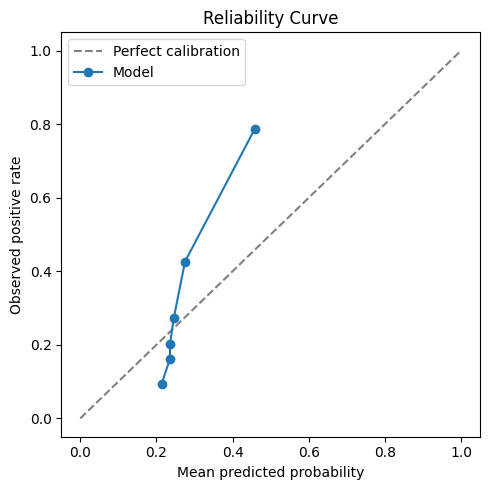

In [10]:
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration')
plt.plot(cal_curve['mean_pred'], cal_curve['frac_pos'], marker='o', label='Model')
plt.xlabel('Mean predicted probability')
plt.ylabel('Observed positive rate')
plt.title('Reliability Curve')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
def customer_topk_metrics(df: pd.DataFrame, k: int = 3) -> pd.DataFrame:
    """Vectorized precision@k and recall@k per customer."""
    df = df.sort_values(['customer_id', 'score'], ascending=[True, False])
    df['rank'] = df.groupby('customer_id').cumcount()
    topk = df[df['rank'] < k]
    precision = topk.groupby('customer_id')['opened'].mean().rename('precision_at_k')
    total_pos = df.groupby('customer_id')['opened'].sum()
    topk_pos = topk.groupby('customer_id')['opened'].sum()
    recall = (topk_pos / total_pos).where(total_pos > 0).rename('recall_at_k')
    return pd.DataFrame({'precision_at_k': precision, 'recall_at_k': recall})


ranking_df = events[['customer_id', 'opened']].copy()
ranking_df['score'] = cal
pr_at3 = customer_topk_metrics(ranking_df, k=3)
pr_at5 = customer_topk_metrics(ranking_df, k=5)

summary_rank = {
    'precision_at_3': float(pr_at3['precision_at_k'].mean()),
    'precision_at_5': float(pr_at5['precision_at_k'].mean()),
    'recall_at_3': float(pr_at3['recall_at_k'].dropna().mean()),
    'recall_at_5': float(pr_at5['recall_at_k'].dropna().mean()),
}
summary_rank

{'precision_at_3': 0.34467767135384825,
 'precision_at_5': 0.31997146932952925,
 'recall_at_3': 0.3484121884930413,
 'recall_at_5': 0.45253570969439}

## 5) What-if Sensitivity

**Intent:** Stress-test recommendations by varying key behavioral features (e.g., recency and purchase-time entropy) and observing how the best predicted probability changes.

In [12]:
base = customers[customers['frequency'] >= 5].median(numeric_only=True).to_dict()
base_profile = {
    'modal_purchase_hour': int(base['modal_purchase_hour']),
    'modal_purchase_dow': int(base['modal_purchase_dow']),
    'purchase_hour_entropy': float(base['purchase_hour_entropy']),
    'avg_daily_txn_count': float(base['avg_daily_txn_count']),
    'recency_days': float(base['recency_days']),
    'frequency': int(base['frequency']),
    'monetary_total': float(base['monetary_total']),
    'tenure_days': int(base['tenure_days']),
    'country_uk': 1,
    'unique_products': int(base['unique_products']),
    'cancellation_rate': 0.0,
}

sensitivity_rows = []
for recency in [10, 30, 60, 120, 240]:
    for entropy in [0.1, 0.3, 0.5, 0.7, 0.9]:
        p = dict(base_profile)
        p['recency_days'] = float(recency)
        p['purchase_hour_entropy'] = float(entropy)
        g = build_168_grid(p)
        s = calibrator.predict(model.predict_proba(g[FEATURE_COLUMNS])[:, 1])
        sensitivity_rows.append({'recency_days': recency, 'entropy': entropy, 'best_prob': float(np.max(s)), 'mean_prob': float(np.mean(s))})

sensitivity = pd.DataFrame(sensitivity_rows)
sensitivity.head(10)

,recency_days,entropy,best_prob,mean_prob
0,10,0.1,0.275107,0.223498
1,10,0.3,0.275107,0.221589
2,10,0.5,0.275107,0.229202
3,10,0.7,0.245331,0.208202
4,10,0.9,0.245331,0.203326
5,30,0.1,0.275107,0.233948
6,30,0.3,0.245331,0.221835
7,30,0.5,0.275107,0.230488
8,30,0.7,0.245331,0.220765
9,30,0.9,0.245331,0.217197


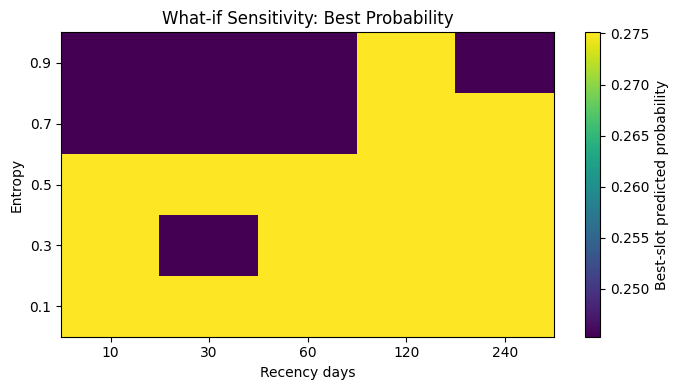

In [13]:
pivot = sensitivity.pivot(index='entropy', columns='recency_days', values='best_prob').sort_index(ascending=False)
plt.figure(figsize=(7, 4))
plt.imshow(pivot.values, aspect='auto', cmap='viridis')
plt.colorbar(label='Best-slot predicted probability')
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), [f'{x:.1f}' for x in pivot.index])
plt.xlabel('Recency days')
plt.ylabel('Entropy')
plt.title('What-if Sensitivity: Best Probability')
plt.tight_layout()
plt.show()

## 6) Policy Simulation

**Intent:** Compare simple operational policies (fixed blast vs segment best slot vs personalized) using historical outcomes as a proxy for expected performance.

> **Caveat:** The "Segment best slot" policy filters to events matching a single dow+hour per segment. With sparse synthetic data this can yield very small sample sizes (sometimes < 50 events), inflating the observed open rate. Interpret the segment-level rate directionally, not as a reliable point estimate.

In [14]:
sim = events.copy()
sim['score'] = cal

# Policy A: fixed blast at Tue 10:00
fixed_dow, fixed_hour = 1, 10
fixed_rate = sim[(sim['send_dow'] == fixed_dow) & (sim['send_hour'] == fixed_hour)]['opened'].mean()

# Policy B: segment modal slot from observed history
hist = campaign.merge(customers[['customer_id', 'rfm_segment']], on='customer_id', how='left')
seg_slot = (
    hist.groupby(['rfm_segment', 'send_dow', 'send_hour'])['opened'].mean()
    .reset_index()
    .sort_values(['rfm_segment', 'opened'], ascending=[True, False])
    .drop_duplicates('rfm_segment')
    [['rfm_segment', 'send_dow', 'send_hour']]
)

seg_events = sim.merge(customers[['customer_id', 'rfm_segment']], on='customer_id', how='left').merge(seg_slot, on='rfm_segment', suffixes=('', '_seg'))
seg_pick = seg_events[(seg_events['send_dow'] == seg_events['send_dow_seg']) & (seg_events['send_hour'] == seg_events['send_hour_seg'])]
seg_rate = seg_pick['opened'].mean()

# Policy C: personalized top-1 from model score within observed events
top1 = sim.sort_values(['customer_id', 'score'], ascending=[True, False]).drop_duplicates('customer_id')
personalized_rate = top1['opened'].mean()

policy_df = pd.DataFrame([
    {'policy': 'Fixed blast (Tue 10:00)', 'expected_open_rate': float(fixed_rate), 'n_events': int(len(sim[(sim['send_dow'] == fixed_dow) & (sim['send_hour'] == fixed_hour)]))},
    {'policy': 'Segment best slot', 'expected_open_rate': float(seg_rate), 'n_events': int(len(seg_pick))},
    {'policy': 'Personalized top-1', 'expected_open_rate': float(personalized_rate), 'n_events': int(len(top1))},
]).sort_values('expected_open_rate', ascending=False)

baseline = policy_df[policy_df['policy'] == 'Fixed blast (Tue 10:00)']['expected_open_rate'].iloc[0]
policy_df['uplift_vs_fixed'] = policy_df['expected_open_rate'] - baseline
policy_df

,policy,expected_open_rate,n_events,uplift_vs_fixed
1,Segment best slot,0.833333,6,0.601734
2,Personalized top-1,0.380273,4907,0.148674
0,Fixed blast (Tue 10:00),0.231599,1576,0.000000


## 7) Opportunity Table

**Intent:** Combine segment size and performance into a simple prioritization table for "where to focus next."

In [15]:
seg_perf = agg[['rfm_segment', 'open_rate']].rename(columns={'rfm_segment': 'segment'})
seg_size = customers['rfm_segment'].value_counts().rename('count').reset_index().rename(columns={'index': 'segment', 'rfm_segment': 'segment'})
seg_table = seg_perf.merge(seg_size, on='segment', how='left')
seg_table['priority_score'] = seg_table['count'] * (1 - seg_table['open_rate'])
seg_table = seg_table.sort_values('priority_score', ascending=False)
seg_table.head(10)

,segment,open_rate,count,priority_score
3,Loyal,0.235353,1430,1093.445385
4,Other,0.239452,1130,859.419313
1,Champions,0.234007,1045,800.462729
0,At Risk,0.235104,1023,782.488332
2,Hibernating,0.245930,707,533.127678


## 8) Diagnostic Summary

In [16]:
diagnostic_summary = {
    'cohort_count': int(ret_rate.shape[0]),
    'reactivation_30d_rate': float(reactivation[30]),
    'slot_stability_rate': float(stability_rate),
    'ece': float(ece),
    'precision_at_3': float(summary_rank['precision_at_3']),
    'policy_best': policy_df.iloc[0]['policy'],
    'policy_best_open_rate': float(policy_df.iloc[0]['expected_open_rate']),
}
diagnostic_summary

{'cohort_count': 25,
 'reactivation_30d_rate': 0.018597355055831537,
 'slot_stability_rate': 0.0511472275334608,
 'ece': 0.06814748980900351,
 'precision_at_3': 0.34467767135384825,
 'policy_best': 'Segment best slot',
 'policy_best_open_rate': 0.8333333333333334}